# 对MOOC课程进行可视化分析

In [2]:
import pandas as pd
import math
import os
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import jieba
from wordcloud import WordCloud
import csv
import matplotlib as  mpl
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn as nn
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import concurrent.futures
import pickle
import re
import json
import requests
from snownlp import SnowNLP
from collections import Counter
from snownlp import sentiment
import random



warnings.filterwarnings('ignore')

# 用来显示中文标签
mpl.rcParams["font.family"] = "SimHei"
# 用来显示负号
mpl.rcParams["axes.unicode_minus"] = False

## 一、前言
根据观察中国大学MOOC课程主页的基本信息，我们可以看到其中包含许多信息。比如：课程名、参加课程人数、授课老师、授课学校等信息。这些可能都是我们在选择观看这门课程前会事先浏览的内容。 

但是这些基本信息对我们学生的价值并不是那么大。通常，我们看一个课程是否有价值，除了成本较高地去且身体会，还以为一种方式，就是点开评论区，看看学生的评价如何。因此我认为一个课的评论，可以被视作这个课程优质与否的重要评价标准。本课题将尝试寻找一种对MOOC网上课程的合适评分方法。

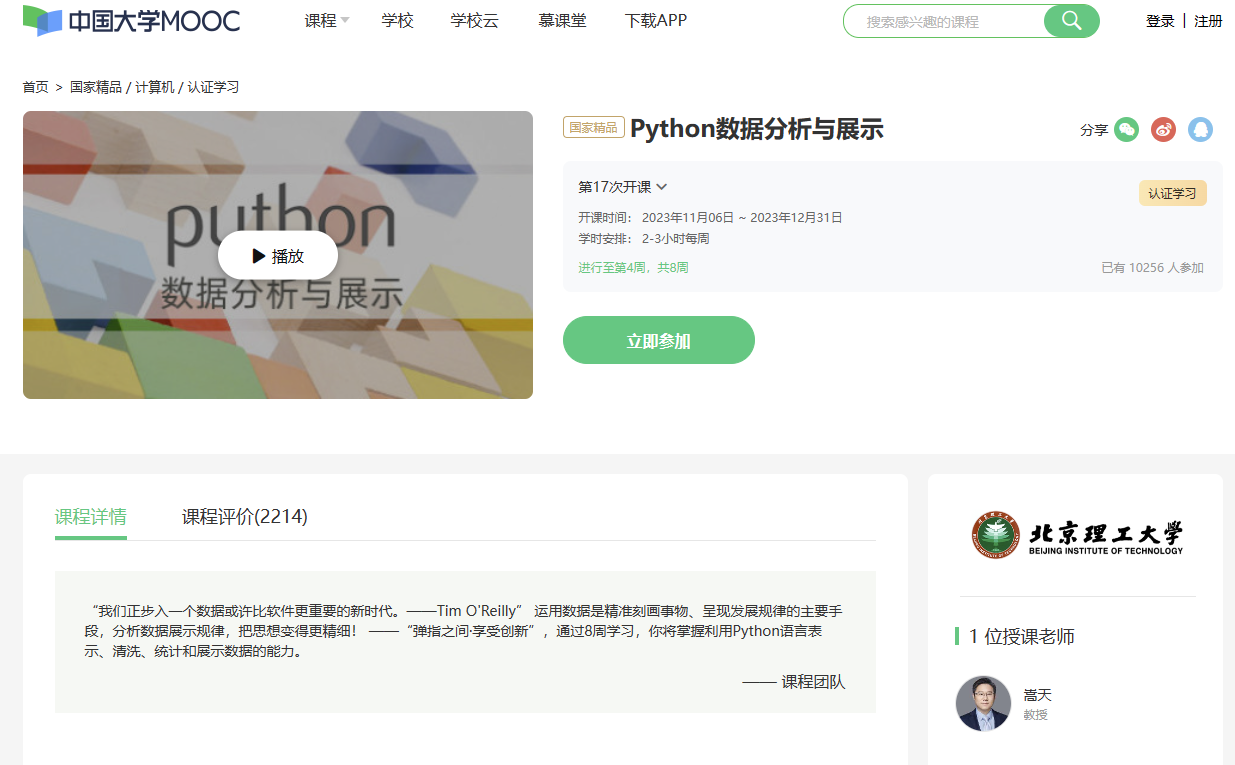

## 二、爬取合适的数据
想要爬取数据，首先我们就要观察课程主页的url是否具有规律。我们以《Python数据分析与展示》为例，它的课程主页url为：`https://www.icourse163.org/course/BIT-1001870002`，可以看出其规律性还是比较明显的，`BIT`是北理工的简称,`1001870002`是该网站唯一的课程号，甚于的内容据观察每个课程都是一样的。



但是通过此url能爬取的内容并不足够让我们充分了解这门课，因此我们还要进一步挖掘更多数据。

可是令人烦恼的是课程主页的源代码居然并不包含评论数据，为了成功获取课程评论，我参考了这篇博文https://blog.csdn.net/Uncle_wangcode/article/details/129181883。
原来需要调用接口才能实现访问评论，于是依照博文给出的代码做适当修改，我也成功爬取了指定MOOC课程的所有评论以及部分基本信息。

到这里，似乎对于普通学生来说，想要获得课程的全部可参考信息已经足够，但是本课题目的在于找到一种通用的课程评价方式，因此我还需要更多信息。

因此，我要尽可能爬取多的课程评论。

那么接下来的任务就是获得课程ID，由于MOOC的页面使用ajax技术动态刷新且网页源代码中同样不具有信息需要调用接口，因此这部分我偷懒使用了网络上已有的课程ID数据。如何通过课程ID批量下载评论数据。

In [3]:
#批量下载评论
def extract_digits(string):
    pattern = r'\d+'
    matches = re.findall(pattern, string)
    digits = ''.join(matches)
    return digits

# 请求头定义
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
}


# 获取课程参与人数和评论
def get_course_participate_comment(courseID):
    # session 实例化
    session = requests.session()
    # 慕课主页url
    index_url = "https://www.icourse163.org/"
    # 慕课主页发起请求，获取后面需要的csrfKey
    index_res = session.get(index_url, headers=HEADERS)
    # 获取csrfKey
    key = index_res.cookies.get("NTESSTUDYSI")

    # 详细课程url
    course_url = "https://www.icourse163.org/course/"+courseID+"?from=searchPage&outVendor=zw_mooc_pcssjg_"
    course_res = session.get(url=course_url,headers=HEADERS)
    # 获取课程参与人数
    deal = re.compile(r'enrollCount : "(.*?)"')
    result = deal.findall(course_res.text)
    participate_person = result[0]

    #课程评论url

    comment_url = f"https://www.icourse163.org/web/j/mocCourseV2RpcBean.getCourseEvaluatePaginationByCourseIdOrTermId.rpc?csrfKey={key}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36",
        "referer": "https://www.icourse163.org/course/"+courseID+"?from=searchPage&outVendor=zw_mooc_pcssjg_",
    }

    # 写入文本文件中


    with open("preview\\"+courseID + ".csv", mode="w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([ "评论内容", "点赞数", "评分"])  # Write header row

        # 获取所有评论数
        for i in range(1, 80):
            param = {
                "courseId": extract_digits(courseID),
                "pageIndex": i,
                "pageSize": "20",
                "orderBy": "3"
            }
            comment_res = session.post(url=comment_url, data=param, headers=headers)
            data = json.loads(comment_res.text)
            for count in range(len(data["result"]["list"])):
                agreecounts = data["result"]["list"][count]["agreeCount"]
                mark = data["result"]["list"][count]["mark"]
                content = data["result"]["list"][count]["content"]
                writer.writerow([content, agreecounts, mark])
            print("数据写入完毕！")


## 三、整合、清洗收集到的数据

对数据进行导入并清洗：

1.所有课程的基本信息，如开设课程的学校、老师、学生人数、课程ID等。这里的数据是不包括评论数据的课程基本内容。


In [5]:
csv_file = 'course_info\\all_course.csv'
df = pd.read_csv(csv_file, encoding='utf-8')
df = df.drop(columns=df.columns[0])  # 删除第一列
df = df.drop_duplicates()  # 去除重复行
df=df.drop_duplicates(subset=['courseID'], keep='last')
df.to_csv(csv_file, index=False)

pd.set_option('display.max_colwidth', 20)
df.head(10)

,stu_num,introduction,link,id,courseID
0,3418,为什么古代服装常见上衣下裳？为什...,http://www.icour...,1002339007,SWJTU-1002339007
1,111,本课程将通过案例讲解，学习使用R...,http://www.icour...,1003385001,BJFU-1003385001
2,848,你，梦想过有一天可以用手机拍摄一...,http://www.icour...,1002937002,HRBNU-1002937002
3,1635,欢迎加入《中国电影经典影片鉴赏》...,http://www.icour...,1003257002,BNU-1003257002
4,941,《 一舞一世界 —世界经典舞蹈赏...,http://www.icour...,1003250002,BNU-1003250002
5,3121,中国传统音乐如诗如画，名曲多如天...,http://www.icour...,1001959013,UESTC-1001959013
6,3745,如果你对数码单反摄影感兴趣，想掌...,http://www.icour...,1002860006,JXNU-1002860006
7,1069,完美的设计表现是设计师取得成功的...,http://www.icour...,1002532003,HNU-1002532003
8,714,从原始人类以石击石的第一声敲击，...,http://www.icour...,1002984006,WHU-1002984006
9,2166,你还在为读不懂古典诗词而感到困扰...,http://www.icour...,1003255003,BNU-1003255003


2.对所有评论的内容、点赞数、对课程的评分。并且去除评论内容中的无效信息。

In [3]:
def process_csv(csv_file):
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')

        # 删除重复行
        df = df.drop_duplicates()

        # 删除缺失数据行
        df = df.dropna()

        df.to_csv(csv_file, index=False)

        df['评论内容'] = df['评论内容'].str.replace('\r|\n', '')
        
        df['评论内容'] = df['评论内容'].str.strip()

        df['评论内容'] = df['评论内容'].str.replace('^[0-9]*$', '')

        df['评论内容'] = df['评论内容'].str.replace(r'^(.)\1*$', '')

    except pd.errors.EmptyDataError:
        print(f"No columns to parse from file: {csv_file}")#大概是没评论的课吧

folder_path = 'preview'
filenames = os.listdir(folder_path)
for filename in filenames:
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        process_csv(file_path)

No columns to parse from file: preview\MSRA-433001.csv
No columns to parse from file: preview\SYXX13-1002931001.csv


## 四、统计点赞数和评分

在爬取数据的过程中我注意到，其实用户评论课程的同时会为课程打分，用户对课程的打分是衡量课程质量一个重要的指标。同时用户也可以对认同的评论点赞，因此评论的点赞数也侧面反映该观点的受支持程度。

这里我们先将所有评论内容汇总到一起，从多角度看一下所有课的评论，方便后续统一处理。

In [ ]:
all_data = pd.DataFrame(columns=['评论内容', '点赞数', '评分'])

for filename in filenames:
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            all_data = all_data.append(df, ignore_index=True)
        except:
            pass
all_data.to_csv('all_data.csv', index=False)


我们可以看一下评论长度的分布，因为评论长度通常代表用户的情感投入。

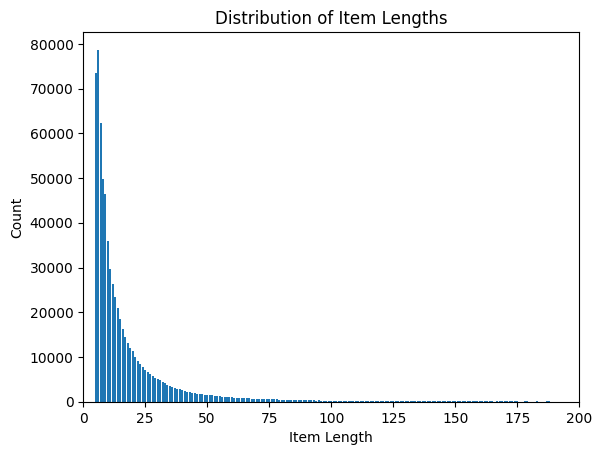

Average Length: 19.044191101261507
Median Length: 11.0


In [3]:
# 读取CSV文件
df = pd.read_csv('all_data.csv')

# 获取item列的内容
items = df['评论内容']

# 统计每个item的字符数，并计算每个长度对应的项目数量
item_lengths = items.str.len()
length_counts = item_lengths.value_counts().sort_index()

# 绘制分布图
plt.bar(length_counts.index, length_counts.values)
plt.xlabel('Item Length')
plt.ylabel('Count')
plt.title('Distribution of Item Lengths')
plt.xlim(0, 200)
plt.show()

average_length = item_lengths.mean()
median_length = item_lengths.median()

# 打印结果
print("Average Length:", average_length)
print("Median Length:", median_length)

我们可以看到评论的平均长度在19，中位数在11。说明大部分评论都比较简短。


但是有时我们读取内容需要依靠分词然确认语句含义，因此统计有效词也很有意义。
下面这段函数的作用是将评论内容进行分词处理，同时去除停用词部分。

In [4]:
df = pd.read_csv('all_data.csv')

def get_custom_stopword(stop_word_file):
    with open(stop_word_file, encoding='utf-8') as f:
        stop_word = f.read()

    stop_word_list = stop_word.split("\n")
    custom_stopword = [i for i in stop_word_list]
    return custom_stopword

stopwords = get_custom_stopword("stopwords.txt")

def tokenize_text(text):
    tokens = jieba.lcut(text)
    tokens_without_stopwords = [token for token in tokens if token not in stopwords]
    return " ".join(tokens_without_stopwords)

df['分词结果'] = df['评论内容'].apply(tokenize_text)

# Save the modified DataFrame to a CSV file
df.to_csv('tokenized_data.csv', index=False)

现在我们已经得到了将评论内容分词的结果，接下来我们再统计一下分词后词语数量的分布。

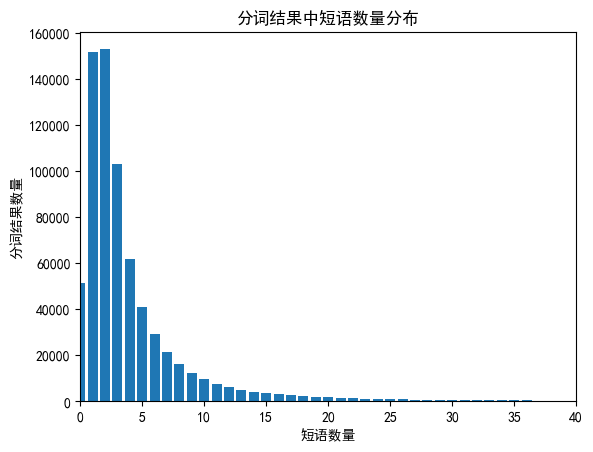

Average Length: 4.287818217979316
Median Length: 2.0


In [6]:
# 读取CSV文件
df = pd.read_csv('tokenized_data.csv')

# 定义一个函数来统计短语数量
def count_phrases(text):
    if pd.isnull(text):  # 检查是否为缺失值
        return 0
    phrases = text.split()
    return len(phrases)

# 对分词结果应用统计函数，得到短语数量列
df['短语数量'] = df['分词结果'].apply(count_phrases)

df.to_csv('tokenized_data.csv', index=False)

# 统计每个短语数量对应的分词结果数量
phrase_counts = df['短语数量'].value_counts().sort_index()

# 绘制短语数量分布图
plt.bar(phrase_counts.index, phrase_counts.values)
plt.xlim(0, 40)
plt.xlabel('短语数量')
plt.ylabel('分词结果数量')
plt.title('分词结果中短语数量分布')
plt.show()

average_length = df['短语数量'].mean()
median_length = df['短语数量'].median()

# 打印结果
print("Average Length:", average_length)
print("Median Length:", median_length)

可以看到分词数量其实非常少，平均只有4.28

我们可以再分析一下点赞数的分布情况。

In [ ]:
conditions = [all_data['点赞数'] == 0,
              all_data['点赞数'] == 1,
              all_data['点赞数'] == 2,
              all_data['点赞数'] == 3,
              all_data['点赞数'] == 4,
              all_data['点赞数'] >= 5]
labels = ['点赞数为0', '点赞数为1', '点赞数为2', '点赞数为3', '点赞数为4', '点赞数为5以上']
counts = [sum(condition) for condition in conditions]

plt.figure(figsize=(6, 6))

plt.pie(counts, labels=labels, autopct='%1.1f%%')

plt.legend(loc='best')
plt.title('点赞数分布情况')

plt.show()

在饼图中可以看到，所有课程中85.5%评论的点赞数都为0，高赞评论只占很小一部分，但是高赞评论作为很多学生都认同的观点，对于帮助我们了解课程质量是非常重要的。

## 五、课程量化评价

接下来我将统计平均评分、含权评分、和各评分的评论数、评分的方差

含权重的均分的计算方法：

最终评分=∑权重*(评分情感)/评论数

权重=(点赞数+1)/log(点赞数+2)。点赞数说明了该评论的受认可程度，但是点赞对课程的褒贬程度我认为不应该超过评论，因此我希望以此方式来保证高赞评论权重的合理性。

评分情感：在目前阶段，我选择将高于3的评论视作正面评论，低于3的视作负面评论，其余则为中性评论。因此计算评分时我将源数据减去期望3再乘以权重以此保证权重可以起到正确的效果。**但是在后续，我会选择一些其他方法来验证该用户的评论与其评分是否相符来避免用户评分错误的问题出现**。

评分的方差则是为了考察学生对课程的评价是否存在两极分化的情况。

现在开始计算每一条评论的权重

In [ ]:
def calculate_likes_weight(likes):
    return (likes+1) / math.log2(likes + 2)

def calculate_likes_right(csv_file):
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')

        # 添加权值列
        df['点赞权值'] = df['点赞数'].apply(calculate_likes_weight)
        #评分情感
        df['评分情感'] = df['评分'].apply(lambda x: 1 if x > 3 else (-1 if x < 3 else 0))

        df.to_csv(csv_file, index=False)

    except:
        pass

for filename in filenames:
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        calculate_likes_right(file_path)

可以看到点赞数高的课会被给予较高权值，但是点赞为0的根据含权重的均分的计算方法也不受影响。

### 但是值得注意的是，有些用户的对课程的评价显然属于负面评价，但是评分确很高，推测是用户评价时忘记评分，因此我们后面会尝试使用文本情感分析模型去推测用户的评价。

In [4]:
df = pd.read_csv('preview\BIT-20018.csv', encoding='utf-8')
pd.set_option('display.max_colwidth', 20)
df.head(10)


,评论内容,点赞数,评分,点赞权值,评分情感,sentiment_prediction_LSTM,sentiment
0,很烂的课，不适合没有基础的学,8,1.0,2.709270,-1,[0.0426710881292...,1
1,讲的内容真的是概括性太强了\n可...,6,3.0,2.333333,0,[0.0964760035276...,1
2,很惊喜，老师讲解的角度很独特，讲...,4,5.0,1.934264,1,[0.0480145439505...,1
3,内容丰富好,1,5.0,1.261860,1,[0.0989791154861...,1
4,学完拉扎维可以回来回忆回忆 比较好,1,5.0,1.261860,1,[0.9960485100746...,-1
5,讲的很好，但适合有一定基础的人看...,1,5.0,1.261860,1,[0.0410543605685...,1
6,去做的多啊,1,5.0,1.261860,1,[0.9438984990119...,-1
7,烂课。。。。有什么意义,0,1.0,1.000000,-1,[0.8844643235206...,-1
8,认识了不少知识，但需要更深入剖析,0,5.0,1.000000,1,[0.0793248564004...,1
9,非常非常棒,0,5.0,1.000000,1,[0.0431523025035...,1


可以通过饼图来了解评分的分布。

In [5]:
plt.figure(figsize=(10, 8))
plt.pie([sum(np.ceil(all_data['评分']) == i) for i in range(1, 6)], labels=[f'{i}星' for i in range(1, 6)], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0'])
plt.title('评分的饼图')
plt.show()


NameError: name 'all_data' is not defined

<Figure size 1000x800 with 0 Axes>

看得出来大部分同学们对大多数课程的满意程度还是比较高的。

接下来我们可以通过散点图分析评分与点赞数的分布。

In [ ]:
x = all_data['点赞数']
y = np.ceil(all_data['评分']).astype(int) 

# 根据点赞数和评分的值为数据点着色
colors = all_data['点赞数']

plt.scatter(x, y, c=colors, cmap='viridis')
plt.colorbar(label='点赞数')

plt.xlabel('点赞数')
plt.ylabel('评分')
plt.title('点赞数与评分的分布情况')
plt.yticks(np.arange(min(y), max(y)+1, 1))

plt.show()

可以看出各评分的评论都有大量点赞数，但是结合之前的统计结果，似乎用户还是更喜欢含蓄的评价。

In [ ]:
def calculate_infos(csv_file):
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')

        # 计算含权评分
        df['含权评分'] = (df['评分'] - 3) * df['点赞权值']

        # 计算∑权重*(评分-3)/评论数的结果
        weighted_rating = (df['含权评分'].sum()) / len(df)

        # 计算各评分的评论数
        rating_counts = df['评分'].value_counts().sort_index()
        df['评论数'] = df['评分'].map(rating_counts)

        # 计算评分的方差
        ratings_variance = np.var(df['评分'])

        # 返回计算结果
        return df['评分'].mean(), weighted_rating, rating_counts, ratings_variance

    except Exception as e:
        #print(f"Error processing file: {csv_file}. Error message: {str(e)}")
        return None, None, None, None

# 获取文件路径
all_course_path = 'course_info\\all_course.csv'
preview_folder_path = 'preview\\'

# 读取 "all_course.csv" 文件
df_all_course = pd.read_csv(all_course_path)

# 逐行处理
for index, row in df_all_course.iterrows():
    link = row['link']
    link_parts = link.split('/')[-1]
    csv_file_name = link_parts + '.csv'
    csv_file_path = os.path.join(preview_folder_path, csv_file_name)

    # 调用计算函数
    mean_rating, weighted_rating, rating_counts, ratings_variance = calculate_infos(csv_file_path)

    if mean_rating is not None:
        # 将计算结果添加到 "all_course.csv" 中的相应行
        df_all_course.loc[index, '平均评分'] = mean_rating
        df_all_course.loc[index, '含权评分'] = weighted_rating
        df_all_course.loc[index, '评分的方差'] = ratings_variance

        # 将各评分的评论数添加为新的列
        # 将各评分的评论数添加为新的列（包括缺失的评分）
        for rating in range(5, 0, -1):
            column_name = f'评分{rating}的评论数'
            count = rating_counts.get(rating, 0)
            df_all_course.loc[index, column_name] = count
    else:
        # 删除对应的行
        df_all_course = df_all_course.drop(index)

# 重置 DataFrame 的索引
df_all_course=df_all_course.drop_duplicates(subset=['courseID'], keep='last')
df_all_course = df_all_course.reset_index(drop=True)
df_all_course.to_csv('new_all_course.csv', index=False)

我们可以了解一下含权评分最低的课是什么样的。

In [ ]:
# 读取CSV文件
df = pd.read_csv('new_all_course.csv')

# 根据某一列的值进行排序
df_sorted = df.sort_values('含权评分')

# 打印结果
print(df_sorted[['courseID','含权评分']].head(20))

如果认为含权评分小于0.5的课质量不高，那么低质量的课看似不多，且评价没有很差的课，但是了解课程主页https://www.icourse163.org/course/HIT-353001，看起来含权评分并不能非常好的解读学生的评价。

anyway，让我们看一下该评分体系下优质课程的一些信息

In [ ]:
# 根据某一列的值进行排序
df_sorted = df.sort_values('含权评分',ascending=False)

# 打印结果
print(df_sorted[['courseID','含权评分']].head(20))

可以看看优质课的词云的低质量课的词云有什么区别。

In [ ]:
def generate_wordcloud(filename):
    path = 'preview\\'+filename+'.csv'
    column_name = '评论内容'

    data = pd.read_csv(path, usecols=[column_name])
    txt = ' '.join(data[column_name].tolist())
    string = ' '.join(jieba.lcut(txt))

    def get_custom_stopword(stop_word_file):
        with open(stop_word_file, encoding='utf-8') as f:
            stop_word = f.read()

        stop_word_list = stop_word.split("\n")
        custom_stopword = [i for i in stop_word_list]
        return custom_stopword

    stopwords = get_custom_stopword("stopwords.txt")
    w = WordCloud(width=1000,
                  height=700,
                  background_color='white',
                  font_path='C:/Windows/SIMLI.TTF',
                  scale=15,
                  stopwords=stopwords,
                  contour_width=5,
                  contour_color='red')

    w.generate(string)
    w.to_file(filename+'_wordcloud.png')
    img1 = mpimg.imread(filename+'_wordcloud.png') # 读取和代码处于同一目录下的 lena.png
    #结果展示
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文乱码
    plt.subplot(121)
    #imshow()对图像进行处理，画出图像，show()进行图像显示
    plt.figure(figsize=(10, 8))
    #不显示坐标轴
    plt.axis('off')
    plt.imshow(img1)


In [ ]:
generate_wordcloud('HIT-353001')

In [ ]:
generate_wordcloud('BUAA-1001807014')

可以看到关键词还是很明显的被展示了的

这里尝试提取一下每个课程评论区最常被提到的十个词，我们可以借此获得一些课程的关键词。

In [16]:
def get_custom_stopwords(stop_word_file):
    with open(stop_word_file, encoding='utf-8') as f:
        stop_word = f.read()

    stop_word_list = stop_word.split("\n")
    custom_stopwords = [i for i in stop_word_list]
    return custom_stopwords

def tokenized(file_path, stopwords):
    df = pd.read_csv(file_path)  # 读取CSV文件

    def tokenize_text(text):
        tokens = jieba.lcut(text)  # 使用结巴分词进行分词
        tokens_without_stopwords = [token for token in tokens if token not in stopwords]  # 去除停用词
        chinese_tokens = [token for token in tokens_without_stopwords if re.match(r'^[\u4e00-\u9fff]+$', token)]
        return chinese_tokens

    # df = df.sort_values('点赞数', ascending=False)
    # df = df.head(20)

    df['tokens'] = df['评论内容'].apply(tokenize_text)  # 对评论内容进行分词并保存到新的列中

    # 将分词结果展开为一个列表
    all_tokens = [token for tokens in df['tokens'] for token in tokens]

    # 计算词频
    word_frequencies = pd.Series(all_tokens).value_counts()

    # 获取出现频率最高的前五个词
    top_10_words = word_frequencies[:10].index.tolist()

    top_10_words_str = ', '.join(top_10_words)

    return top_10_words_str


stopwords = get_custom_stopwords("stopwords.txt")  # 获取自定义停用词列表

all_course_path = 'new_all_course.csv'
preview_folder_path = 'preview\\'

# 读取 "all_course.csv" 文件
df_all_course = pd.read_csv(all_course_path)

# 逐行处理
for index, row in df_all_course.iterrows():
    link = row['link']
    link_parts = link.split('/')[-1]
    csv_file_name = link_parts + '.csv'
    csv_file_path = os.path.join(preview_folder_path, csv_file_name)

    # 调用计算函数
    try:
        top_10_words = tokenized(csv_file_path,stopwords)
        df_all_course.loc[index, 'top_10_words'] = top_10_words
    except:
        pass

# 重置 DataFrame 的索引
df_all_course=df_all_course.drop_duplicates(subset=['courseID'], keep='last')
df_all_course = df_all_course.reset_index(drop=True)
df_all_course.to_csv('new_all_course.csv', index=False)

### 六、尝试使用模型预测一下评论的情感倾向(此部分是本人的探索内容，最终实现效果并不理想，但是依旧耗费了很多心血，所以希望将此部分内容保留下来，我认为这部分工作也是很有意义的，因为如果训练出合适的模型，那么对于缺少用户评分机制的课程网站，这个模型将很有用)

1.使用非常方便的snownlp库来处理、训练模型，测试结果

In [ ]:
df = pd.read_csv('preview/HIT-353001.csv')
def get_sentiment_cn(text):
    s = SnowNLP(text)
    return s.sentiments
df["sentiment"] = df['评论内容'].apply(get_sentiment_cn)
print(df)

由于SnowNLP语料库本身是基于购物评论内容，很遗憾直接使用SnowNLP模型效果并不理想，其不能识别出评论中的不满情感。

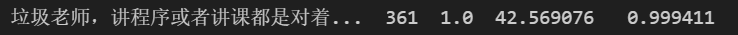

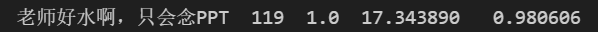

所以我们应当使用合适的数据集来训练模型达到效果。但是采用人工标注对于我们的结课作业显然是不合理的。很幸运，经过授权，我获得了本校老师在其研究中标注的数据集(但是数据集本身比较小，对于模型的训练效果经过实测并不是特别好，但其实我看到有不少师范类学校做过类似的评论情感标注，期待越来越多的数据集能被公开使用！)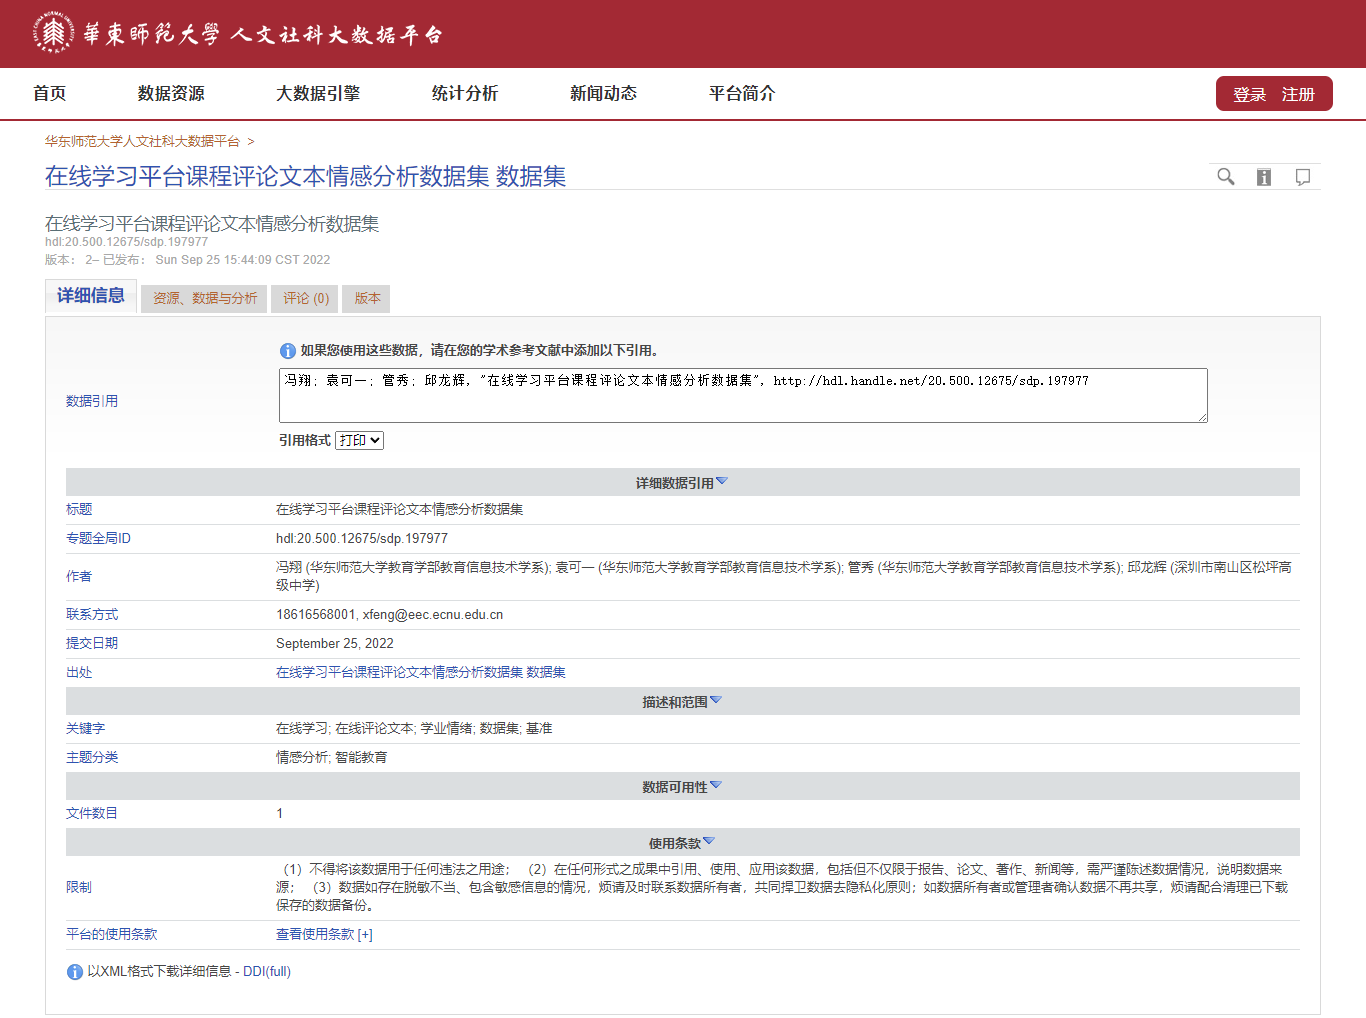

接下来使用在线学习课程平台课程评论文本情感分析数据集.tab来作为训练数据。这里使用snownlp作为训练模型。

我将数据集中的情感简单地分为正向和负向。

正面情绪：

高兴、希望、放松、兴趣。

负面情绪：

失望、气愤、焦虑、厌倦、羞愧

来源：冯翔; 袁可一; 管秀; 邱龙辉, "在线学习平台课程评论文本情感分析数据集", http://hdl.handle.net/20.500.12675/sdp.197977


In [4]:
def process_item(df):
    df['item'] = df['item'].str.split('；', n=1, expand=True)[0]
    df['item'] = df['item'].str.replace('\r|\n', '')
    df['item'] = df['item'].str.strip()
    df['item'] = df['item'].str.replace('^[0-9]*$', '')
    df['item'] = df['item'].str.replace(r'^(.)\1*$', '')


# 读取 Excel 文件
df = pd.read_excel('anotation_result.xlsx')

# 将情感映射为正向或负向
positive_emotions = ['高兴', '希望', '放松', '兴趣']
negative_emotions = ['失望', '气愤', '焦虑', '厌倦', '羞愧']

df['sentiment'] = df['emotion'].apply(lambda x: 1 if x in positive_emotions else 0)

# 计算训练集和测试集的切分点
split_index = int(0.8 * len(df))

# 获取训练集和测试集数据
train_df = df[:split_index]
test_df = df[split_index:]
process_item(train_df)
process_item(test_df)

positive_train_texts = train_df[train_df['sentiment'] == 1]['item'].tolist()

with open('positive_train_dataset.txt', 'w', encoding='utf-8') as f:
    for text in positive_train_texts:
        f.write(f'{text}\n')

# 保存负向情感训练集的 item 到文本文件
negative_train_texts = train_df[train_df['sentiment'] == 0]['item'].tolist()

with open('negative_train_dataset.txt', 'w', encoding='utf-8') as f:
    for text in negative_train_texts:
        f.write(f'{text}\n')

# 保存测试集的 item 和 sentiment 到 Excel 文件
test_texts = test_df['item'].str.split('；', n=1, expand=True)[0].tolist()
test_sentiments = test_df['sentiment'].tolist()

test_data = pd.DataFrame({'item': test_texts, 'sentiment': test_sentiments})

test_data.to_excel('test_dataset.xlsx', index=False)

现在已经得到了训练语料库和测试集，接下来继续使用snownlp探究一下其情感分析能力，如果准确率高那么将可以直接用作课程评论区的情感倾向来更准确地评分。

In [6]:
#对语料库进行训练，把路径改成相应的位置。
sentiment.train('negative_train_dataset.txt', 'positive_train_dataset.txt') 
#这一步是对上一步的训练结果进行保存，如果以后语料库没有改变，下次不用再进行训练，直接使用就可以了，所以一定要保存，保存位置可以自己决定，但是要把`snownlp/seg/__init__.py`里的`data_path`也改成你保存的位置，不然下次使用还是默认的。
sentiment.save('entiment.marshal')

同时我也保留了部分评论作为测试集，用来测试模型的准确度，我想60%并不是一个很好的结果。

In [10]:
#//是转义的方式。表示这里\\是一个普通\字符，不容易出错
text = pd.read_excel(r'test_dataset.xlsx')
#text0读取text数据框的第一列的所有数据
text0=text.iloc[:,0]
senti=[SnowNLP(i).sentiments for i in text0]
newsenti=[]
for i in senti:
    if (i>=0.5):
        newsenti.append(1)
    else:
        newsenti.append(0)
#将新的预测标签增加为text的某一列，所以现在text的第0列为评论文本，第1列为实际标签，第2列为预测标签
text['predict']=newsenti
counts=0
#遍历所有标签，将预测标签和实际标签进行比较，相同则判断正确。
for j in range(len(text.iloc[:,0])): 
    if text.iloc[j,2]==text.iloc[j,1]:
        counts+=1
#输出本次预测的准确率
print(u"准确率为:%f"%(float(counts)/float(len(text))))

准确率为:0.676889


因此我们有两条路径可以选择：

一、使用现有的语料分析模型或平台api对评论进行标注产生数据集（要是能调用gpt4.0就好了，有点贵就是说，但是效果肯定不错。不过这里我申请到了百度的情感分析平台的api），再使用这些生成式数据集训练模型。但是经过我使用snownlp的模型预测与自己训练的LSTM模型进行测试，准确率都不高。显然这种方法有些南辕北辙。

二、以评论的现有评分为情感倾向产生数据集，使用该数据集生成模型，测试该模型准确度与现有语料分析模型或平台的准确度差异。


### 二、以评论的现有评分为情感倾向产生数据集，使用该数据集生成模型

现在我将采集所有课程的评论，将其加入为正向情感文本和负向情感文本。

In [6]:
def process_item(df):
    df['评论内容'] = df['评论内容'].str.split('；', n=1, expand=True)[0]
    df['评论内容'] = df['评论内容'].str.replace('\r|\n', '')
    df['评论内容'] = df['评论内容'].str.strip()
    df['评论内容'] = df['评论内容'].str.replace('^[0-9]*$', '')
    df['评论内容'] = df['评论内容'].str.replace(r'^(.)\1*$', '')
    df['评论内容'] = df['评论内容'].apply(remove_illegal_characters)  # 新增代码，移除非法字符

def remove_illegal_characters(text):
    illegal_chars = re.compile(r'[\000-\010]|[\013-\014]|[\016-\037]')  # 匹配非法字符的正则表达式
    return re.sub(illegal_chars, '', text)

# 读取 Excel 文件
df = pd.read_csv('all_data.csv')

df['评分情感'] = df['评分'].apply(lambda x: 1 if x > 3 else (-1 if x < 3 else 0))

# 计算训练集和测试集的切分点
split_index = int(0.9 * len(df))

# 获取训练集和测试集数据
train_df = df[:split_index]
test_df = df[split_index:]
process_item(train_df)
process_item(test_df)

positive_train_texts = train_df[train_df['评分情感'] == 1]['评论内容'].tolist()

with open('positive_train_raw.txt', 'w', encoding='utf-8') as f:
    for text in positive_train_texts:
        f.write(f'{text}\n')

# 保存负向情感训练集的 item 到文本文件
negative_train_texts = train_df[train_df['评分情感'] == -1]['评论内容'].tolist()

with open('negative_train_raw.txt', 'w', encoding='utf-8') as f:
    for text in negative_train_texts:
        f.write(f'{text}\n')

# 保存测试集的 item 和 sentiment 到 Excel 文件
test_texts = test_df['评论内容'].tolist()
test_sentiments = test_df['评分情感'].tolist()

test_data = pd.DataFrame({'评论内容': test_texts, '评分情感': test_sentiments})
test_data['评论内容'] = test_data['评论内容'].apply(remove_illegal_characters)  # 移除非法字符

test_data.to_excel('test_raw.xlsx', index=False)

现在如果不考虑用户的评分标错的情况，我们直接根据用户评分来判断评论的情感。并将相关语料放入snopwnlp训练。

In [3]:
#对语料库进行训练，把路径改成相应的位置。
sentiment.train('negative_train_raw.txt', 'positive_train_raw.txt') 
#这一步是对上一步的训练结果进行保存，如果以后语料库没有改变，下次不用再进行训练，直接使用就可以了，所以一定要保存，保存位置可以自己决定，但是要把`snownlp/seg/__init__.py`里的`data_path`也改成你保存的位置，不然下次使用还是默认的。
sentiment.save('entiment.marshal')

现在我们计算准确率，在大数据量的训练下，可以看到准确率还是不错的，就是效率有点低，应该是分词用了太久。但是可惜的是用户的真实情感与对课程评分不匹配的情况不能得到去除。而且训练耗时十分久。在后续我们可以看到LTSM在使用更少训练时间的情况下实现了与snownlp相同的匹配度。

In [15]:
# 读取数据
df = pd.read_csv('results.csv')

# 将评论内容列转换为字符串类型
df['评论内容'] = df['评论内容'].astype(str)

# 进行情感预测
df['senti_score'] = df['评论内容'].apply(lambda x: SnowNLP(x).sentiments)

# 根据情感得分进行预测标签的转换
df['predict'] = df['senti_score'].apply(lambda x: 1 if x >= 0.5 else -1)

# 计算准确率
valid_df = df[df['评分情感'] != 0]
accuracy = len(valid_df[valid_df['predict'] == valid_df['评分情感']]) / len(valid_df)

# 输出准确率
print("准确率为: %f" % accuracy)

valid_df.to_csv('valid_df.csv', index=False)


准确率为: 0.939675


现在我将所有评论的情感倾向进行预测。以待后续使用。

In [7]:
def predict(data_path):
        output_column = 'sentiment_prediction_snownlp'  # 新列的名称
        sentiment_column = 'sentiment_snownlp'  # 新列的名称

        # 读取CSV文件
        df = pd.read_csv(data_path)

        # 将情感倾向预测结果保存到新列中
        df[output_column] = df['评论内容'].apply(lambda x: SnowNLP(x).sentiments)

        # 根据情感得分进行预测标签的转换
        df[sentiment_column] = df[output_column].apply(lambda x: 1 if x > 0.6 else (-1 if x < 0.4 else 0))

        # 保存更新后的CSV文件
        df.to_csv(data_path, index=False)


if __name__ == '__main__':
    folder_path = 'preview'
    filenames = os.listdir(folder_path)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # 提交每个文件的预测任务给线程池
        future_to_file = {executor.submit(predict, os.path.join(folder_path, filename)): filename for filename in filenames if filename.endswith('.csv')}

        # 获取结果
        for future in concurrent.futures.as_completed(future_to_file):
            file_path = future_to_file[future]
            try:
                future.result()
            except Exception as e:
                print(f"Failed to predict file: {file_path}, Error: {str(e)}")

Failed to predict file: MSRA-433001.csv, Error: No columns to parse from file
Failed to predict file: SYXX13-1002931001.csv, Error: No columns to parse from file


为了验证有没有更好的模型，我将使用LTSM尝试将用户评分作为情感标注进行训练。

In [6]:
class SentimentNet(nn.Module):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

    def __init__(self, vocab_size, input_dim, hid_dim, layers, output_dim):
        super(SentimentNet, self).__init__()
        self.n_layers = layers
        self.hidden_dim = hid_dim
        self.embeding_dim = input_dim
        self.output_dim = output_dim
        drop_prob = 0.5

        self.lstm = nn.LSTM(self.embeding_dim, self.hidden_dim, self.n_layers,
                            dropout=drop_prob, batch_first=True).to(self.device)

        self.fc = nn.Linear(in_features=self.hidden_dim, out_features=self.output_dim).to(self.device)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(drop_prob)

        self.embedding = nn.Embedding(vocab_size, self.embeding_dim).to(self.device)

    def forward(self, x, hidden):
        x = x.long().to(self.device)
        embeds = self.embedding(x).to(self.device)

        lstm_out, hidden = self.lstm(embeds, hidden)
        out = self.dropout(lstm_out)
        out = self.fc(out).to(self.device)
        out = self.sigmoid(out)
        out = out[:, -1, :]
        out = out.squeeze()
        out = out.contiguous().view(-1)
        return out, hidden

    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device))
        return hidden

In [7]:
data_path = 'all_data.csv'
df = pd.read_csv(data_path)
original_rows = df.shape[0]  # 原始行数

# 删除重复行
df = df.drop_duplicates()



new_rows = df.shape[0]  # 删除重复行且评分情感不为0后的行数

x = df['评论内容']
df['评分情感'] = df['评分'].apply(lambda x: 1 if x > 3 else (-1 if x < 3 else 0))
df = df[df['评分情感'] != 0]
df.to_csv('new_all_data.csv', index=False)

print("原始行数：", original_rows)
print("删除重复行且评分情感不为0后的行数：", new_rows)

原始行数： 703920
删除重复行且评分情感不为0后的行数： 560103


In [4]:
if __name__ == '__main__':

    data_path = 'new_all_data.csv'
    df = pd.read_csv(data_path)
    df = df.sample(frac=1, random_state=1)

    # 只取打乱后数据的前10%
    #df = df.head(int(df.shape[0] * 0.01))

        # 选择评分情感为1和-1的数据
    df = df[df['评分情感'].isin([1, -1])]

    # 分别选择评分情感为1和-1的5000条数据
    positive_df = df[df['评分情感'] == 1].sample(n=50000, random_state=1)
    negative_df = df[df['评分情感'] == -1].sample(n=15000, random_state=1)

    # 合并数据
    df = pd.concat([positive_df, negative_df])


    x = df['评论内容']
    y = df['评分情感']


    texts_cut = [jieba.lcut(one_text) for one_text in x]

    label_set = set()
    for label in y:
        label_set.add(label)
    label_set = np.array(list(label_set))

    labels_one_hot = []
    for label in y:
        label_zero = np.zeros(len(label_set))
        label_zero[np.in1d(label_set, label)] = 1
        labels_one_hot.append(label_zero)
    labels = np.array(labels_one_hot)

    num_words = 3000
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(texts=texts_cut)
    num_words = min(num_words, len(tokenizer.word_index) + 1)

    sentence_len = 5

    texts_seq = tokenizer.texts_to_sequences(texts=texts_cut)
    texts_pad_seq = pad_sequences(texts_seq, maxlen=sentence_len, padding='post', truncating='post')

    # 拆分训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(texts_pad_seq, labels, test_size=0.2, random_state=1)

    train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    test_dataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model = SentimentNet(num_words, 256, 128, 8, 2)

    lr = 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

    epochs = 32
    step = 0
    epoch_loss_list = []
    model.train()  # 开启训练模式

    for epoch in range(epochs):
        epoch_loss = 0
        for index, (x_train, y_train) in enumerate(train_loader):
            cur_batch = len(x_train)
            h = model.init_hidden(cur_batch) # 初始化第一个Hidden_state

            x_train, y_train = x_train.to(device), y_train.to(device)
            step += 1  # 训练次数+1

            x_input = x_train.to(device)
            model.zero_grad()

            output, h = model(x_input, h)
            output=output.to(device)
            # 计算损失
            loss = criterion(output, y_train.float().view(-1))
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            epoch_loss += loss.item()

        print("Epoch: {}/{}...".format(epoch + 1, epochs),
              "Step: {}...".format(step),
              "Loss: {:.6f}...".format(epoch_loss))

        epoch_loss_list.append(epoch_loss)

    # 保存模型
    torch.save(model.state_dict(), 'model.pth')


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\32375\AppData\Local\Temp\jieba.cache
Loading model cost 0.329 seconds.
Prefix dict has been built successfully.


Epoch: 1/32... Step: 1625... Loss: 779.143029...
Epoch: 2/32... Step: 3250... Loss: 662.161772...
Epoch: 3/32... Step: 4875... Loss: 616.863628...
Epoch: 4/32... Step: 6500... Loss: 592.338163...
Epoch: 5/32... Step: 8125... Loss: 574.478290...
Epoch: 6/32... Step: 9750... Loss: 560.470198...
Epoch: 7/32... Step: 11375... Loss: 547.502506...
Epoch: 8/32... Step: 13000... Loss: 536.905797...
Epoch: 9/32... Step: 14625... Loss: 525.115198...
Epoch: 10/32... Step: 16250... Loss: 512.689762...
Epoch: 11/32... Step: 17875... Loss: 502.275910...
Epoch: 12/32... Step: 19500... Loss: 493.839759...
Epoch: 13/32... Step: 21125... Loss: 485.209601...
Epoch: 14/32... Step: 22750... Loss: 474.302595...
Epoch: 15/32... Step: 24375... Loss: 466.312141...
Epoch: 16/32... Step: 26000... Loss: 459.247607...
Epoch: 17/32... Step: 27625... Loss: 449.982401...
Epoch: 18/32... Step: 29250... Loss: 439.461985...
Epoch: 19/32... Step: 30875... Loss: 435.735823...
Epoch: 20/32... Step: 32500... Loss: 426.01420

In [7]:
    model.eval()
    loss = 0
    for data in tqdm(test_loader):
        x_val, y_val = data
        x_val, y_val = x_val.to(device), y_val.to(device)

        h = model.init_hidden(len(x_val))  # 初始化第一个Hidden_state

        x_input = x_val.long()
        x_input = x_input.to(device)
        output, h = model(x_input, h)
        output=output.to(device)
        loss += criterion(output, y_val.float().view(-1))

    print("test Loss: {:.6f}...".format(loss))

    test_text_cut = [jieba.lcut("这老师只会读ppt，真的不行，垃圾"),
                     jieba.lcut("讲得好详细"),
                     jieba.lcut("根本听不懂"),
                     jieba.lcut("五颗星，讲得深入浅出，太棒了，很喜欢老师，谢谢")]

    
    test_seq = tokenizer.texts_to_sequences(texts=test_text_cut)
    print(test_seq)
    test_pad_seq = pad_sequences(test_seq, maxlen=sentence_len, padding='post', truncating='post')
    h = model.init_hidden(len(test_pad_seq))

    output, h = model(torch.tensor(test_pad_seq), h)
    print(output.view(-1,2))

    for label in label_set:
        print(label)

    x = [epoch + 1 for epoch in range(epochs)]
    plt.plot(x, epoch_loss_list)

    plt.xlim(0, 32)
    plt.ylim(0, 1000)
    plt.show()

    tokenizer_file = 'tokenizer.pkl'
    with open(tokenizer_file, 'wb') as f:
        pickle.dump(tokenizer, f)


NameError: name 'model' is not defined

In [8]:
num_words = 3000
model = SentimentNet(num_words, 256, 128, 8, 2)  # 创建一个新的模型实例
model.load_state_dict(torch.load('model.pth'))

# 定义函数来进行分词和情感预测
def process_comments(comments):

    sentence_len = 5

    # 进行分词和去除停用词
    comments_cut = [jieba.lcut(text) for text in comments]

    tokenizer_file = 'tokenizer.pkl'

    # 加载词汇表文件
    with open(tokenizer_file, 'rb') as f:
        tokenizer = pickle.load(f)


    # 将分词后的文本转换为序列
    test_seq = tokenizer.texts_to_sequences(texts=comments_cut)

    # 对序列进行填充
    test_pad_seq = pad_sequences(test_seq, maxlen=sentence_len, padding='post', truncating='post')

    # 初始化隐藏层
    h = model.init_hidden(len(test_pad_seq))

    # 获取情感倾向预测结果
    output, h = model(torch.tensor(test_pad_seq), h)

    # 返回情感倾向预测结果
    return output.view(-1, 2)

def predict(data_path):
    try:
        output_column = 'sentiment_prediction_LSTM'  # 新列的名称
        sentiment_column = 'sentiment_LSTM'  # 新列的名称

        # 读取CSV文件
        df = pd.read_csv(data_path)

        # 提取评论列
        comments = df['评论内容']

        # 处理评论并获取情感倾向预测结果
        predictions = process_comments(comments)

        # 将情感倾向预测结果保存到新列中
        df[output_column] = predictions.detach().cpu().numpy().tolist()

        # 添加"sentiment"列
        df[sentiment_column] = np.where(predictions.detach().cpu()[:, 0] > 0.6, 1, np.where(predictions.detach().cpu()[:, 0] < 0.4, -1, 0))

        # 保存更新后的CSV文件
        df.to_csv(data_path, index=False)
    except:
        pass

if __name__ == '__main__':
    folder_path = 'preview'
    filenames = os.listdir(folder_path)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # 提交每个文件的预测任务给线程池
        future_to_file = {executor.submit(predict, os.path.join(folder_path, filename)): filename for filename in filenames if filename.endswith('.csv')}

        # 获取结果
        for future in concurrent.futures.as_completed(future_to_file):
            file_path = future_to_file[future]
            try:
                future.result()
            except Exception as e:
                print(f"Failed to predict file: {file_path}, Error: {str(e)}")

In [12]:
# 读取数据
df = pd.read_csv('results.csv')

comments = df['评论内容'].astype(str)

predictions = process_comments(comments)

df['output_column'] = predictions.detach().cpu().numpy().tolist()


df['sentiment_column'] = np.where(predictions.detach().cpu()[:, 0] > 0.5, 1, np.where(predictions.detach().cpu()[:, 0] < 0.5, -1, 0))

# 计算准确率
valid_df = df[df['评分情感'] != 0]
accuracy = len(valid_df[valid_df['sentiment_column'] == valid_df['评分情感']]) / len(valid_df)

# 输出准确率
print("准确率为: %f" % accuracy)

准确率为: 0.938410


这里我的设想是我将用用户主动填写的评分代表的情感与我用snownlp和LTSM模型预测的结果作比较，如果三者结果一致，那么我认为评分的情感是准确的，但是如果不一致，我会调用百度提供的情感分析api，输入这条评论的内容返回一个预测结果，再四者比较，只要其中有三个是一致的，那么就把这个值作为最后预测情感结果，如果不一致，会赋值为一个特殊值并且再最后评价课程时这条评论不会被纳入考量范围，但是这种情况比较少，因为预测模型最后的准确度都不错并且用户主动填写的评分也并没有那么多出错的情况。但是如此处理时间消耗有点恐怖，处理一个721条信息花了80秒，筛除了14个异常评论。但是所有评论一共有78万条，最后可能要花80*780000/721秒左右，大约是一整天。而且我现在的设备由于可能的主板故障，一天会重启四五次，很显然即使多线程工作也不能满足需求。

In [11]:
API_KEY = "KWtdCiEoAUjKta6xdO0F8MPp"
SECRET_KEY = "ZwInRIbOV5j5PUhyWL3xbgm4qg9Y503O"

def baidu_predict(comment):
        
    url = "https://aip.baidubce.com/rpc/2.0/nlp/v1/sentiment_classify?charset=UFT-8&access_token=" + get_access_token()
    
    payload = json.dumps({
        "text": comment
    })
    headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json'
    }
    
    response = requests.request("POST", url, headers=headers, data=payload)
    try:
        response_json = response.json()
        positive_prob = response_json['items'][0]['positive_prob']
        return(positive_prob)
    except (KeyError, IndexError):
        print("Unable to extract positive_prob from the response.")
    

def get_access_token():
    url = "https://aip.baidubce.com/oauth/2.0/token"
    params = {"grant_type": "client_credentials", "client_id": API_KEY, "client_secret": SECRET_KEY}
    return str(requests.post(url, params=params).json().get("access_token"))



def compare_sentiments(csv_file):
    # 读取CSV文件
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        rows = list(reader)

    # 遍历每一行并逐行检查情感值
    for row in rows:
        # 获取当前行的情感值
        sentiment_value = row['评分情感']
        sentiment_snownlp_value = row['sentiment_snownlp']
        sentiment_LTSM_value = row['sentiment']

        # 检查三列的内容是否一致
        if sentiment_value == sentiment_snownlp_value == sentiment_LTSM_value:
            # 如果三列的内容一致，设置check_sentiment列为相同的值
            row['check_sentiment'] = sentiment_value
        else:
            # 如果三列的内容不一致，调用baidu_predict函数获取返回值
            comment = row['评论内容']
            baidu_result = baidu_predict(comment)
            if baidu_result > 0.6:
                baidu_result = 1
            elif baidu_result < 0.4:
                baidu_result = -1
            else:
                baidu_result = 0

            # 检查评分情感、sentiment和sentiment_snownlp与baidu_predict返回值是否一致
            values = [sentiment_value, sentiment_snownlp_value, sentiment_LTSM_value, baidu_result]
            counter = Counter(values)

            most_common = counter.most_common(2)
            if len(most_common) == 1 or (len(most_common) == 2 and most_common[0][1] != most_common[1][1]):
                # 如果出现次数最多的值只有一个，或者出现次数最多的两个值次数不相等，则设置check_sentiment列为出现次数最多的值
                row['check_sentiment'] = most_common[0][0]
            else:
                # 如果无法确定出现次数最多的值，则设置check_sentiment列为2
                row['check_sentiment'] = 2

    # 更新CSV文件的check_sentiment列
    fieldnames = reader.fieldnames + ['check_sentiment']

    with open(csv_file, 'w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

compare_sentiments('preview\BDU-1001765002.csv')

# if __name__ == '__main__':
#     folder_path = 'preview'
#     filenames = os.listdir(folder_path)
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         # 提交每个文件的预测任务给线程池
#         future_to_file = {executor.submit(compare_sentiments, os.path.join(folder_path, filename)): filename for filename in filenames if filename.endswith('.csv')}

#         # 获取结果
#         for future in concurrent.futures.as_completed(future_to_file):
#             file_path = future_to_file[future]
#             try:
#                 future.result()
#             except Exception as e:
#                 print(f"Failed to predict file: {file_path}, Error: {str(e)}")

这个就快多了，并且经过实测，最终效果与调用百度api的方法所实现的效果所差无几。

In [15]:
def compare_sentiments(csv_file):
    # 读取CSV文件
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        rows = list(reader)

    # 遍历每一行并逐行检查情感值
    for row in rows:
        # 获取当前行的情感值
        sentiment_value = row['评分情感']
        sentiment_snownlp_value = row['sentiment_snownlp']
        sentiment_LTSM_value = row['sentiment']

        # 检查三列的内容是否一致
        if sentiment_value == sentiment_snownlp_value or sentiment_value == sentiment_LTSM_value:
            # 如果 sentiment_value 与 sentiment_snownlp_value 或 sentiment_LTSM_value 相同
            row['check_sentiment'] = sentiment_value
        elif sentiment_snownlp_value == sentiment_LTSM_value:
            # 如果 sentiment_snownlp_value 与 sentiment_LTSM_value 相同
            row['check_sentiment'] = sentiment_snownlp_value
        else:
            row['check_sentiment'] = 2

    # 更新CSV文件的check_sentiment列
    fieldnames = reader.fieldnames + ['check_sentiment']

    with open(csv_file, 'w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)


if __name__ == '__main__':
    folder_path = 'preview'
    filenames = os.listdir(folder_path)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # 提交每个文件的预测任务给线程池
        future_to_file = {executor.submit(compare_sentiments, os.path.join(folder_path, filename)): filename for filename in filenames if filename.endswith('.csv')}

        # 获取结果
        for future in concurrent.futures.as_completed(future_to_file):
            file_path = future_to_file[future]
            try:
                future.result()
            except Exception as e:
                print(f"Failed to predict file: {file_path}, Error: {str(e)}")

删除check_sentiment为异常值的行保证准确性。

In [10]:
def remove_rows_by_value(csv_file):
    # 读取CSV文件
    df = pd.read_csv(csv_file)

    # 删除指定列值为特定值的行
    df = df[df['check_sentiment'] != 2]

    # 保存修改后的结果到CSV文件
    df.to_csv(csv_file, index=False)

if __name__ == '__main__':
    folder_path = 'preview'
    filenames = os.listdir(folder_path)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # 提交每个文件的预测任务给线程池
        future_to_file = {executor.submit(remove_rows_by_value, os.path.join(folder_path, filename)): filename for filename in filenames if filename.endswith('.csv')}

        # 获取结果
        for future in concurrent.futures.as_completed(future_to_file):
            file_path = future_to_file[future]
            try:
                future.result()
            except Exception as e:
                print(f"Failed to predict file: {file_path}, Error: {str(e)}")


既然我们已经获得了更准确的用户情感，那么现在让我们来尝试重新评价课程。

In [17]:
def calculate_infos(csv_file):
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')

        # 计算含权评分
        df['标准含权评分'] = abs(df['评分'] - 3) * df['点赞权值'] * df['check_sentiment']

        # 计算∑权重*(评分-3)/评论数的结果
        weighted_rating = (df['标准含权评分'].sum()) / len(df)


        # 返回计算结果
        return weighted_rating

    except Exception as e:
        return None

# 获取文件路径
all_course_path = 'new_all_course.csv'
preview_folder_path = 'preview\\'

# 读取 "all_course.csv" 文件
df_all_course = pd.read_csv(all_course_path)

# 逐行处理
for index, row in df_all_course.iterrows():
    link = row['link']
    link_parts = link.split('/')[-1]
    csv_file_name = link_parts + '.csv'
    csv_file_path = os.path.join(preview_folder_path, csv_file_name)

    try:
        weighted_rating = calculate_infos(csv_file_path)
        df_all_course.loc[index, '标准含权评分'] = weighted_rating
    except:
        pass


# 重置 DataFrame 的索引
df_all_course=df_all_course.drop_duplicates(subset=['courseID'], keep='last')
df_all_course = df_all_course.reset_index(drop=True)
df_all_course.to_csv('new_all_course.csv', index=False)

看一下新评分体系高评分的课有什么变化

In [19]:
# 读取CSV文件
df = pd.read_csv('new_all_course.csv')

# 根据某一列的值进行排序
df_sorted = df.sort_values('含权评分',ascending=False)

# 打印结果
print(df_sorted[['courseID','含权评分']].head(20))

df_sorted = df.sort_values('标准含权评分',ascending=False)

# 打印结果
print(df_sorted[['courseID','标准含权评分']].head(20))

              courseID      含权评分
578    BUAA-1001807014  6.382685
904       UESTC-500002  6.110417
343     BNU-1002842007  6.051664
715    NWPU-1001959005  5.363169
1064   WHUT-1001821007  4.933988
1690    SEU-1002193001  4.888982
656   NJUPT-1002147001  4.720996
837       SWJTU-410003  4.704536
157     SDU-1002485001  4.479018
688    NWPU-1002531020  4.457827
683     WHU-1002332010  4.436786
546     NEU-1002920013  4.106805
1666        SDU-400003  3.884801
440    DLMU-1002929003  3.845271
266     BIT-1001871001  3.804664
1141    SDU-1002535008  3.769229
779       TONGJI-89003  3.733564
1618         NUDT-9004  3.728038
249   HAUST-1001796013  3.706874
1177   SNNU-1002699014  3.698016
              courseID    标准含权评分
578    BUAA-1001807014  6.293212
904       UESTC-500002  6.094143
343     BNU-1002842007  5.931899
715    NWPU-1001959005  5.345970
1064   WHUT-1001821007  5.052298
656   NJUPT-1002147001  4.882358
1690    SEU-1002193001  4.766611
683     WHU-1002332010  4.588090
837       

我们可以看到排名出现了变化，那就说明此评分方法是有意义的，尽管在此处难以体现，但是如果将此运用在B站、YouTube的缺少学生评分课程类视频下，那么将能更好的帮助学生了解这个课程的优质程度。

现在我们可以尝试为一门课加上侧面画像。

In [ ]:
# -*- encoding:utf-8 -*-
import requests
import re
import json
import csv

def extract_digits(string):
    pattern = r'\d+'
    matches = re.findall(pattern, string)
    digits = ''.join(matches)
    return digits

# 请求头定义
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
}


# 获取课程参与人数和评论
def get_course_participate_comment(courseID):
    # session 实例化
    session = requests.session()
    # 慕课主页url
    index_url = "https://www.icourse163.org/"
    # 慕课主页发起请求，获取后面需要的csrfKey
    index_res = session.get(index_url, headers=HEADERS)
    # 获取csrfKey
    key = index_res.cookies.get("NTESSTUDYSI")

    # 详细课程url
    course_url = "https://www.icourse163.org/course/"+courseID+"?from=searchPage&outVendor=zw_mooc_pcssjg_"
    course_res = session.get(url=course_url,headers=HEADERS)
    # 获取课程参与人数
    deal = re.compile(r'enrollCount : "(.*?)"')
    result = deal.findall(course_res.text)
    participate_person = result[0]

    #课程评论url

    comment_url = f"https://www.icourse163.org/web/j/mocCourseV2RpcBean.getCourseEvaluatePaginationByCourseIdOrTermId.rpc?csrfKey={key}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36",
        "referer": "https://www.icourse163.org/course/"+courseID+"?from=searchPage&outVendor=zw_mooc_pcssjg_",
    }

    # 写入文本文件中


    with open("preview\\" + courseID + ".csv", mode="w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["评论内容", "点赞数", "评分"])  # Write header row

        # 获取所有评论数
        for i in range(1, 80):
            param = {
                "courseId": extract_digits(courseID),
                "pageIndex": i,
                "pageSize": "20",
                "orderBy": "3"
            }
            comment_res = session.post(url=comment_url, data=param, headers=headers)
            data = json.loads(comment_res.text)
            for count in range(len(data["result"]["list"])):
                agreecounts = data["result"]["list"][count]["agreeCount"]
                mark = data["result"]["list"][count]["mark"]
                content = data["result"]["list"][count]["content"]
                writer.writerow([content, agreecounts, mark])
                # 存储数据到列表
                data_list.append([content, agreecounts, mark])
            print("数据写入完毕！")

    # 将列表转换为DataFrame
    df = pd.DataFrame(data_list, columns=["评论内容", "点赞数", "评分"])


if __name__ == '__main__':
    link=input("请输入课程主页网址")
    link_parts = link.split('/')[-1]
    get_course_participate_comment(link_parts)

